# TP Bubble Raft - à la maison - notebook II

Now you will use a simulation of a bubble raft to observe the relaxation dynamics after the raft has been "mixed". The simulation uses the method of Molecular Dynamics (MD), provided by the software package called JAX, M.D.

### ABOUT JAX, M.D.

##### End-to-End Differentiable, Hardware Accelerated, Molecular Dynamics in Pure Python

Molecular dynamics is a workhorse of modern computational condensed matter physics. It is frequently used to simulate materials to observe how small scale interactions can give rise to complex large-scale phenomenology. Most molecular dynamics packages (e.g. HOOMD Blue or LAMMPS) are complicated, specialized pieces of code that are many thousands of lines long. They typically involve significant code duplication to allow for running simulations on CPU and GPU. Additionally, large amounts of code is often devoted to taking derivatives of quantities to compute functions of interest (e.g. gradients of energies to compute forces).

However, recent work in machine learning has led to significant software developments that might make it possible to write more concise molecular dynamics simulations that offer a range of benefits. Here we target JAX, which allows us to write python code that gets compiled to XLA and allows us to run on CPU, GPU, or TPU. Moreover, JAX allows us to take derivatives of python code. Thus, not only is this molecular dynamics simulation automatically hardware accelerated, it is also end-to-end differentiable. This should allow for some interesting experiments that we're excited to explore.

JAX, MD is a research project that is currently under development. Expect sharp edges and possibly some API breaking changes as we continue to support a broader set of simulations. JAX MD is a functional and data driven library. Data is stored in arrays or tuples of arrays and functions transform data from one state to another.

## This notebook

You will start by generating a system of particles, and letting it relax to the lowest energy state using MD simulation. You will also relax the system after mixing up the particles. In these processes you will:

    - Observe the most favorable lattice formed by particles in 2D
    - Explore the presence of lattice defects, and their evolution during system relaxation
    - Employ pair correlation functions to characterize the relaxed system

## Load packages and initialize functions

In [ ]:
!pip install -q git+https://www.github.com/google/jax-md
!pip install seaborn

In [1]:
import time 

from functools import partial
import numpy as onp

import jax.numpy as np

from jax.api import jit
from jax.api import grad
from jax.api import vmap
from jax.api import value_and_grad

from jax import random
from jax import lax

from jax.experimental import stax
from jax.experimental import optimizers

from jax.config import config
config.update('jax_enable_x64', True)

from jax_md import space
from jax_md import minimize
from jax_md import simulate
from jax_md import space
from jax_md import energy
from jax_md import quantity

from IPython.display import HTML, display
import time

                                        #### FUNCTIONS ####
#############################################################################################################
##########################################  FROM JAX MD  ####################################################


def ProgressIter(iter_fun, iter_len=0):
    if not iter_len:
        iter_len = len(iter_fun)
    out = display(progress(0, iter_len), display_id=True)
    for i, it in enumerate(iter_fun):
        yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y):  
    plt.xlabel(x, fontsize=20)
    plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
    plt.gcf().set_size_inches(
        shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
        shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
    plt.tight_layout()
    
f32 = np.float32
f64 = np.float64

def box_size_at_number_density(particle_count, number_density):
    return f32((particle_count / number_density) ** 0.5)

def pair_correlation_fun(dist_fun, cutoff=2.0, bin_count=60, sigma=None):
  """Calculates the pair correlation function for a collection of atoms."""
    if sigma is None:
        sigma = cutoff / bin_count
    bins = np.linspace(0.1, cutoff, bin_count)

    dist_fun = vmap(vmap(dist_fun, (0, None)), (None, 0))
    def compute(R):
        # TODO(cubuk): Change this function to do batched calculation, as it can
        # require too much memory for more than 1000 particles.
        dr = dist_fun(R, R)
        dr = np.where(dr > 1e-7, dr, 1e7)
        dim = R.shape[1]
        exp = np.exp(-0.5 * (dr[:, :, np.newaxis] - bins) ** 2 / sigma ** 2)
        gaussian_distances = exp / np.sqrt(2 * np.pi * sigma ** 2)
        return np.mean(gaussian_distances, axis=1) / bins ** (dim - 1)
    return compute

def draw_system(R, box_size, marker_size, color=None):
    if color == None:
        color = [64 / 256] * 3
    ms = marker_size / box_size

    R = onp.array(R)

    marker_style = dict(
        linestyle='none', 
        markeredgewidth=3,
        marker='o', 
        markersize=ms, 
        color=color, 
        fillstyle='none')

    plt.plot(R[:, 0], R[:, 1], **marker_style)
    plt.plot(R[:, 0] + box_size, R[:, 1], **marker_style)
    plt.plot(R[:, 0], R[:, 1] + box_size, **marker_style)
    plt.plot(R[:, 0] + box_size, R[:, 1] + box_size, **marker_style)
    plt.plot(R[:, 0] - box_size, R[:, 1], **marker_style)
    plt.plot(R[:, 0], R[:, 1] - box_size, **marker_style)
    plt.plot(R[:, 0] - box_size, R[:, 1] - box_size, **marker_style)

    plt.xlim([0, box_size])
    plt.ylim([0, box_size])
    plt.axis('off')


def square_lattice(N, box_size):
    Nx = int(np.sqrt(N))
    Ny, ragged = divmod(N, Nx)
    if Ny != Nx or ragged:
        assert ValueError('Particle count should be a square. Found {}.'.format(N))
    length_scale = box_size / Nx
    R = []
    for i in range(Nx):
        for j in range(Ny):
            R.append([i * length_scale, j * length_scale])
    return np.array(R)
#############################################################################################################
def pairCorrelationFunction_2D(x, y, S, rMax, dr):
    # taken from  @cfinch Github #
    """Compute the two-dimensional pair correlation function, also known
    as the radial distribution function, for a set of circular particles
    contained in a square region of a plane.  This simple function finds
    reference particles such that a circle of radius rMax drawn around the
    particle will fit entirely within the square, eliminating the need to
    compensate for edge effects.  If no such particles exist, an error is
    returned. Try a smaller rMax...or write some code to handle edge effects! ;)
    Arguments:
        x               an array of x positions of centers of particles
        y               an array of y positions of centers of particles
        S               length of each side of the square region of the plane
        rMax            outer diameter of largest annulus
        dr              increment for increasing radius of annulus
    Returns a tuple: (g, radii, interior_indices)
        g(r)            a numpy array containing the correlation function g(r)
        radii           a numpy array containing the radii of the
                        annuli used to compute g(r)
        reference_indices   indices of reference particles
        
   
    """
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram
    # Number of particles in ring/area of ring/number of reference particles/number density
    # area of ring = pi*(r_outer**2 - r_inner**2)

    # Find particles which are close enough to the box center that a circle of radius
    # rMax will not cross any edge of the box
    bools1 = x > rMax
    bools2 = x < (S - rMax)
    bools3 = y > rMax
    bools4 = y < (S - rMax)
    interior_indices, = where(bools1 * bools2 * bools3 * bools4)
    num_interior_particles = len(interior_indices)

    if num_interior_particles < 1:
        raise  RuntimeError ("No particles found for which a circle of radius rMax\
                will lie entirely within a square of side length S.  Decrease rMax\
                or increase the size of the square.")

    edges = arange(0., rMax + 1.1 * dr, dr)
    num_increments = len(edges) - 1
    g = zeros([num_interior_particles, num_increments])
    radii = zeros(num_increments)
    numberDensity = len(x) / S**2

    # Compute pairwise correlation for each interior particle
    for p in range(num_interior_particles):
        index = interior_indices[p]
        d = sqrt((x[index] - x)**2 + (y[index] - y)**2)
        d[index] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, normed=False)
        g[p, :] = result/numberDensity

    # Average g(r) for all interior particles and compute radii
    g_average = zeros(num_increments)
    for i in range(num_increments):
        radii[i] = (edges[i] + edges[i+1]) / 2.
        rOuter = edges[i + 1]
        rInner = edges[i]
        g_average[i] = mean(g[:, i]) / (pi * (rOuter**2 - rInner**2))

    return (g_average, radii, interior_indices)

## Relaxing to the optimal lattice

First generate $N$ bubbles on a square grid. Feel free to play with the numerical parameters to get a feeling of what they do.

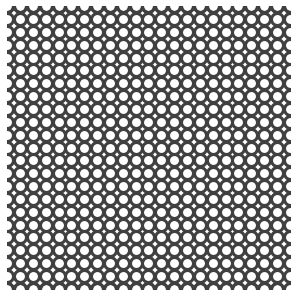

In [92]:
N = 512 # numer of bubbles
box_size = box_size_at_number_density(particle_count=N, number_density=1)
r = square_lattice(N, box_size)
draw_system(r, box_size, 270.0)
finalize_plot((0.75, 0.75))

Now let the system relax. The code below calls a JAX function for the brownian dynamics simulation. The main parameters to play with are the simulation time **simulation_steps**, time increment **dt**, **temperature** and the positions of the bubbles **r**. First run a short relaxation with 10000 steps. Afterwards plot the final bubble raft.

In [93]:
displacement_fun, shift_fun = space.periodic(box_size)
energy_fun = energy.soft_sphere_pair(displacement_fun)
print('Energy of the system, U = {:f}'.format(energy_fun(r)))
key = random.PRNGKey(0)

simulation_steps = 10000
dt = 1e-1
temperature = 2e-5

init_fun, apply_fun = simulate.brownian(energy_fun, shift_fun, dt, temperature)
apply_fun = jit(apply_fun)
state = init_fun(key, r)

for step in ProgressIter(range(simulation_steps)):
    state = apply_fun(state)    

Energy of the system, U = 10.999990


Energy of the system, U = 0.002808


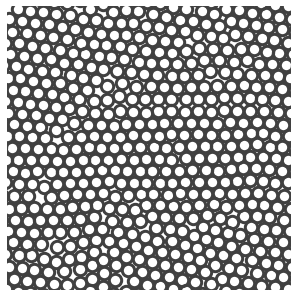

In [94]:
print('Energy of the system, U = {:f}'.format(energy_fun(state.position)))
draw_system(state.position, box_size, 280.0)
finalize_plot((0.75, 0.75))

Now run the relaxation much longer and compare the final raft with the previous one.

In [95]:
displacement_fun, shift_fun = space.periodic(box_size)
energy_fun = energy.soft_sphere_pair(displacement_fun)
print('Energy of the system, U = {:f}'.format(energy_fun(r)))
key = random.PRNGKey(0)

simulation_steps = 30000
dt = 1e-1
temperature = 2e-5

init_fun, apply_fun = simulate.brownian(energy_fun, shift_fun, dt, temperature)
apply_fun = jit(apply_fun)
stateLonger = init_fun(key, r)

for step in ProgressIter(range(simulation_steps)):
    stateLonger = apply_fun(stateLonger)    

Energy of the system, U = 10.999990


Energy of the system, U = 0.001130


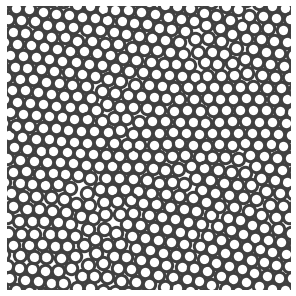

In [96]:
print('Energy of the system, U = {:f}'.format(energy_fun(stateLonger.position)))
draw_system(stateLonger.position, box_size, 280.0)
finalize_plot((0.75, 0.75))

What would be the ideal lattice if sufficient relaxations removed all defects?

What happens to the raft after longer relaxation, in particular concerning the defects?

## Recrystalization

Mix the system --- the simplest way to do it is to increase the temperature and aggitate it that way.

In [97]:
displacement_fun, shift_fun = space.periodic(box_size)
energy_fun = energy.soft_sphere_pair(displacement_fun)
print('Energy of the system, U = {:f}'.format(energy_fun(stateLonger.position)))
key = random.PRNGKey(0)

simulation_steps = 10000
dt = 1e-1
temperature = 2e-1

init_fun, apply_fun = simulate.brownian(energy_fun, shift_fun, dt, temperature)
apply_fun = jit(apply_fun)
stateMix = init_fun(key, stateLonger.position)

for step in ProgressIter(range(simulation_steps)):
    stateMix = apply_fun(stateMix)

Energy of the system, U = 0.001130


Energy of the system, U = 56.392078


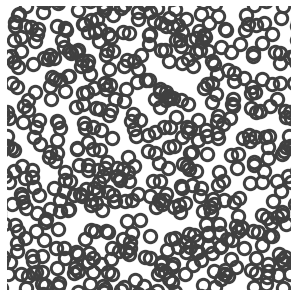

In [98]:
print('Energy of the system, U = {:f}'.format(energy_fun(stateMix.position)))
draw_system(stateMix.position, box_size, 280.0)
finalize_plot((0.75, 0.75))   

Now start from the raft **stateMix** just obtained, and let it relax again.

In [99]:
displacement_fun, shift_fun = space.periodic(box_size)
energy_fun = energy.soft_sphere_pair(displacement_fun)
print('Energy of the system, U = {:f}'.format(energy_fun(stateMix.position)))
key = random.PRNGKey(0)

simulation_steps = 10000
dt = 1e-1
temperature = 2e-5

init_fun, apply_fun = simulate.brownian(energy_fun, shift_fun, dt, temperature)
apply_fun = jit(apply_fun)
stateRelax = init_fun(key, stateMix.position)

for step in ProgressIter(range(simulation_steps)):
    stateRelax = apply_fun(stateRelax)

Energy of the system, U = 56.392078


Energy of the system, U = 0.002137


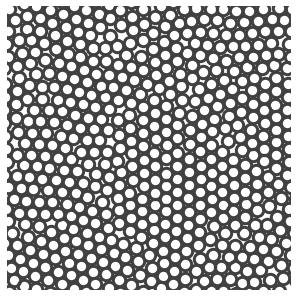

In [100]:
print('Energy of the system, U = {:f}'.format(energy_fun(stateRelax.position)))
draw_system(stateRelax.position, box_size, 280.0)
finalize_plot((0.75, 0.75)) 

How would you produce the agitated state of bubbles in experiment?

Is the final relaxed raft obtained from randomly agitated bubbles similar to the final relaxed raft obtained from square lattice?

## Characterization of rafts: pair correlations

Use the previously introduced pair correlation function $g_{\textrm{dist}}(r)$ to quantify the crystallinity of several raft obtained above.

Comment on the different results.

In [110]:
gaverageSimInit, radiiiSimInit, interior_indicesSimInit = pairCorrelationFunction_2D(r[:,0], r[:,1], 300, 10, 0.1)
gaverageSimLonger, radiiiSimLonger, interior_indicesSimLonger = pairCorrelationFunction_2D(stateLonger.position[:,0], stateLonger.position[:,1], 300, 10, 0.1)
gaverageSimMix, radiiiSimMix, interior_indicesSimMix = pairCorrelationFunction_2D(stateMix.position[:,0], stateMix.position[:,1], 300, 10, 0.1)
gaverageSimRelax, radiiiSimRelax, interior_indicesSimRelax = pairCorrelationFunction_2D(stateRelax.position[:,0], stateRelax.position[:,1], 300, 10, 0.1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.


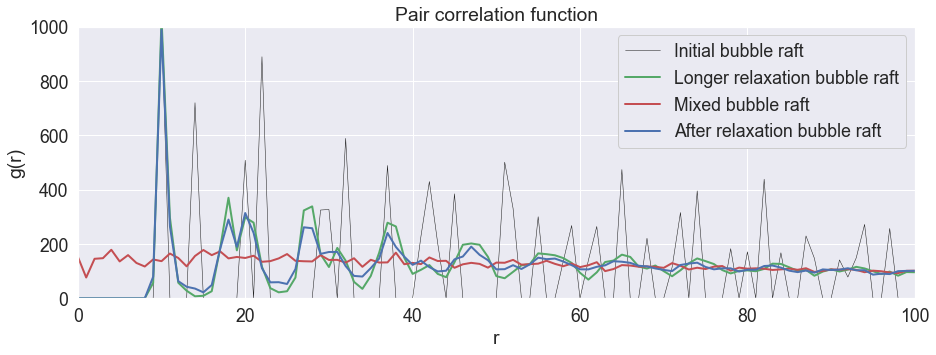

In [114]:
plt.figure(figsize = (15,5))
plt.xlim([0, 100])
plt.ylim([0, 1000])
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title('Pair correlation function')
plt.plot(gaverageSimInit, 'k', linewidth=0.5, label='Initial bubble raft')
plt.plot(gaverageSimLonger, 'g', linewidth=2, label='Longer relaxation bubble raft')
plt.plot(gaverageSimMix, 'r', linewidth=2, label='Mixed bubble raft')
plt.plot(gaverageSimRelax, 'b', linewidth=2, label='After relaxation bubble raft')
plt.legend(framealpha=1, frameon=True)